# Test de Indicadores Técnicos Básicos

Este notebook demuestra el uso de los indicadores técnicos básicos del módulo.

## Objetivo

Mostrar cómo:
1. Cargar y limpiar datos
2. Calcular indicadores de diferentes categorías
3. Visualizar resultados
4. Interpretar los indicadores

**NOTA**: Este notebook solo calcula indicadores. No genera señales de trading.

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Añadir src al path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Importar módulos del proyecto
from src.data import DataProvider, DataCleaner
from src.analisis.technical.indicators import trend, momentum, volatility, volume, price_action

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. Cargar y Limpiar Datos

In [2]:
# Crear provider y obtener datos
provider = DataProvider()
symbol = "AAPL"
print(f"Descargando datos para {symbol}...")

raw_data = provider.get_price_data(symbol, period="1y", interval="1d")
print(f"Datos descargados: {len(raw_data)} períodos")
print(f"Rango de fechas: {raw_data.index.min()} a {raw_data.index.max()}")

# Limpiar datos
cleaner = DataCleaner()
cleaned_data, metadata = cleaner.clean_price_data(raw_data, symbol=symbol)
print(f"\nDatos limpiados. Forma final: {cleaned_data.shape}")
print(f"Columnas disponibles: {list(cleaned_data.columns)}")

Descargando datos para AAPL...


INFO:src.data.raw.data_yahoo_finance:Datos cargados desde cache: AAPL_price_1y_1d.pkl
INFO:src.data.raw.data_yahoo_finance:Usando datos de cache expirado para AAPL


Datos descargados: 251 períodos


INFO:src.data.cleaning.data_cleaner:Limpiando datos de precios para AAPL...


Rango de fechas: 2025-01-14 00:00:00-05:00 a 2026-01-13 00:00:00-05:00


INFO:src.data.cleaning.data_cleaner:Limpieza completada. Filas: 251 -> 251



Datos limpiados. Forma final: (251, 12)
Columnas disponibles: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits', 'returns', 'log_returns', 'price_change', 'pct_change', 'volatility_20']


## 2. Indicadores de Tendencia

### SMA y EMA

Medias móviles calculadas:
                 close       SMA_8      SMA_18      SMA_40       EMA_8  \
Date                                                                     
2026-01-07  260.329987  269.132496  271.829441  273.842499  267.410687   
2026-01-08  259.040009  267.337498  270.774441  273.582749  265.550536   
2026-01-09  259.369995  265.538746  269.723885  273.185749  264.177083   
2026-01-12  260.250000  263.934998  268.953886  272.855249  263.304398   
2026-01-13  261.049988  262.583748  268.200553  272.557748  262.803418   

                EMA_18      EMA_40      HMA_20  
Date                                            
2026-01-07  270.650513  270.447207  267.756060  
2026-01-08  269.428355  269.890758  265.284508  
2026-01-09  268.369580  269.377550  262.832354  
2026-01-12  267.514888  268.932304  260.763943  
2026-01-13  266.834372  268.547801  259.232496  


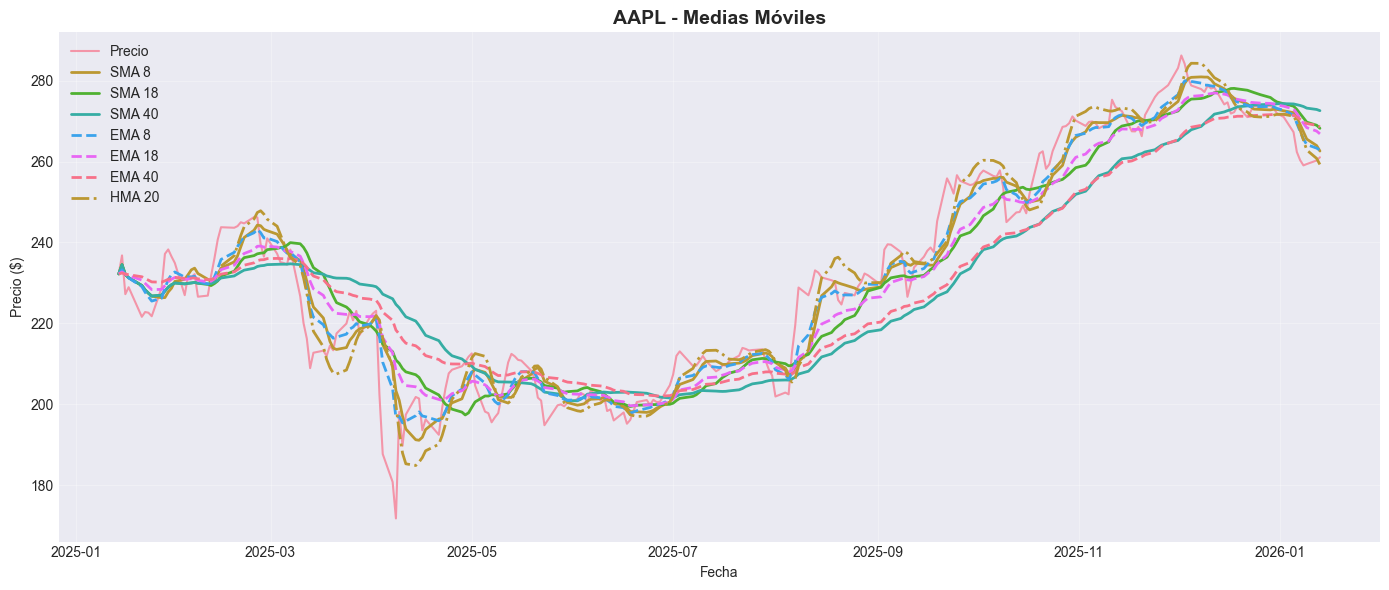

In [3]:
# Calcular SMAs y EMAs (8, 18, 40) + HMA (20)
df = trend.calculate_sma_series(cleaned_data.copy())
df = trend.calculate_ema_series(df)
df = trend.calculate_hma(df, period=20, output_column='HMA_20')

print("Medias móviles calculadas:")
print(df[['close', 'SMA_8', 'SMA_18', 'SMA_40', 'EMA_8', 'EMA_18', 'EMA_40', 'HMA_20']].tail())

# Visualizar
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df.index, df['close'], label='Precio', linewidth=1.5, alpha=0.7)
ax.plot(df.index, df['SMA_8'], label='SMA 8', linewidth=2)
ax.plot(df.index, df['SMA_18'], label='SMA 18', linewidth=2)
ax.plot(df.index, df['SMA_40'], label='SMA 40', linewidth=2)
ax.plot(df.index, df['EMA_8'], label='EMA 8', linewidth=2, linestyle='--')
ax.plot(df.index, df['EMA_18'], label='EMA 18', linewidth=2, linestyle='--')
ax.plot(df.index, df['EMA_40'], label='EMA 40', linewidth=2, linestyle='--')
ax.plot(df.index, df['HMA_20'], label='HMA 20', linewidth=2, linestyle='-.')
ax.set_title(f'{symbol} - Medias Móviles', fontsize=14, fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio ($)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Indicadores de Momentum

### RSI

RSI actual: 32.45


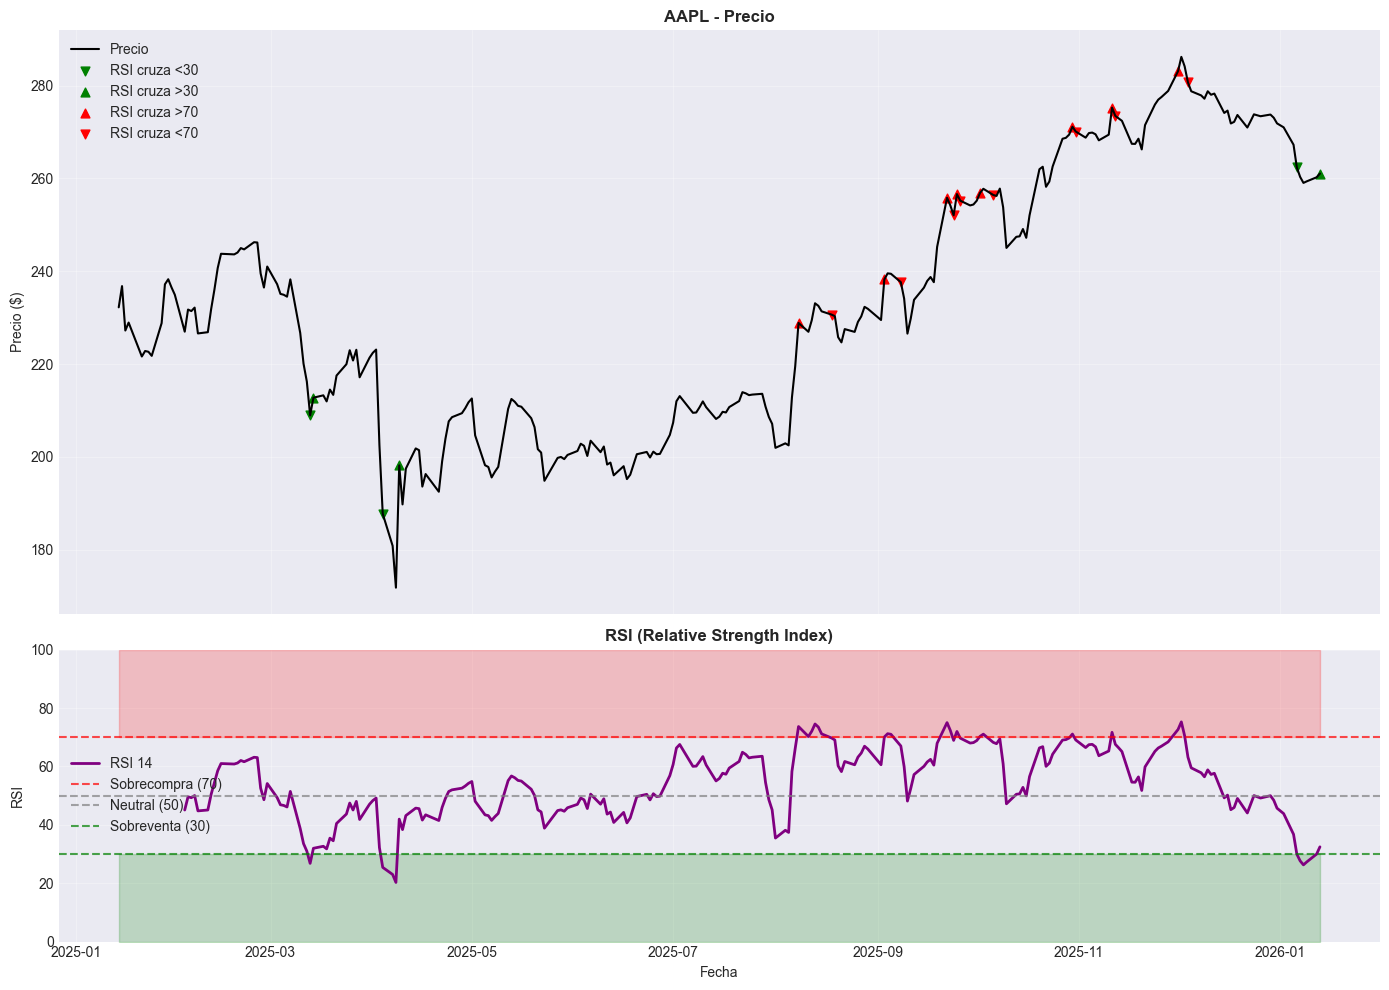

In [4]:
# Calcular RSI
df = momentum.calculate_rsi(df, period=14, output_column='RSI_14')

print(f"RSI actual: {df['RSI_14'].iloc[-1]:.2f}")

# Visualizar RSI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, height_ratios=[2, 1])
ax1.plot(df.index, df['close'], label='Precio', linewidth=1.5, color='black')

rsi = df['RSI_14']
lower_rsi = 30
mid_rsi = 50
upper_rsi = 70

cross_down_lower = (rsi < lower_rsi) & (rsi.shift(1) >= lower_rsi)
cross_up_lower = (rsi > lower_rsi) & (rsi.shift(1) <= lower_rsi)
cross_up_upper = (rsi > upper_rsi) & (rsi.shift(1) <= upper_rsi)
cross_down_upper = (rsi < upper_rsi) & (rsi.shift(1) >= upper_rsi)

ax1.scatter(df.index[cross_down_lower], df.loc[cross_down_lower, 'close'],
            color='green', marker='v', s=40, label='RSI cruza <30')
ax1.scatter(df.index[cross_up_lower], df.loc[cross_up_lower, 'close'],
            color='green', marker='^', s=40, label='RSI cruza >30')
ax1.scatter(df.index[cross_up_upper], df.loc[cross_up_upper, 'close'],
            color='red', marker='^', s=40, label='RSI cruza >70')
ax1.scatter(df.index[cross_down_upper], df.loc[cross_down_upper, 'close'],
            color='red', marker='v', s=40, label='RSI cruza <70')

ax1.set_title(f'{symbol} - Precio', fontsize=12, fontweight='bold')
ax1.set_ylabel('Precio ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(df.index, df['RSI_14'], label='RSI 14', linewidth=2, color='purple')
ax2.axhline(y=upper_rsi, color='r', linestyle='--', alpha=0.7, label='Sobrecompra (70)')
ax2.axhline(y=mid_rsi, color='gray', linestyle='--', alpha=0.7, label='Neutral (50)')
ax2.axhline(y=lower_rsi, color='g', linestyle='--', alpha=0.7, label='Sobreventa (30)')
ax2.fill_between(df.index, upper_rsi, 100, alpha=0.2, color='red')
ax2.fill_between(df.index, 0, lower_rsi, alpha=0.2, color='green')
ax2.set_title('RSI (Relative Strength Index)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('RSI')
ax2.set_ylim(0, 100)
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### ADX y Stochastic RSI

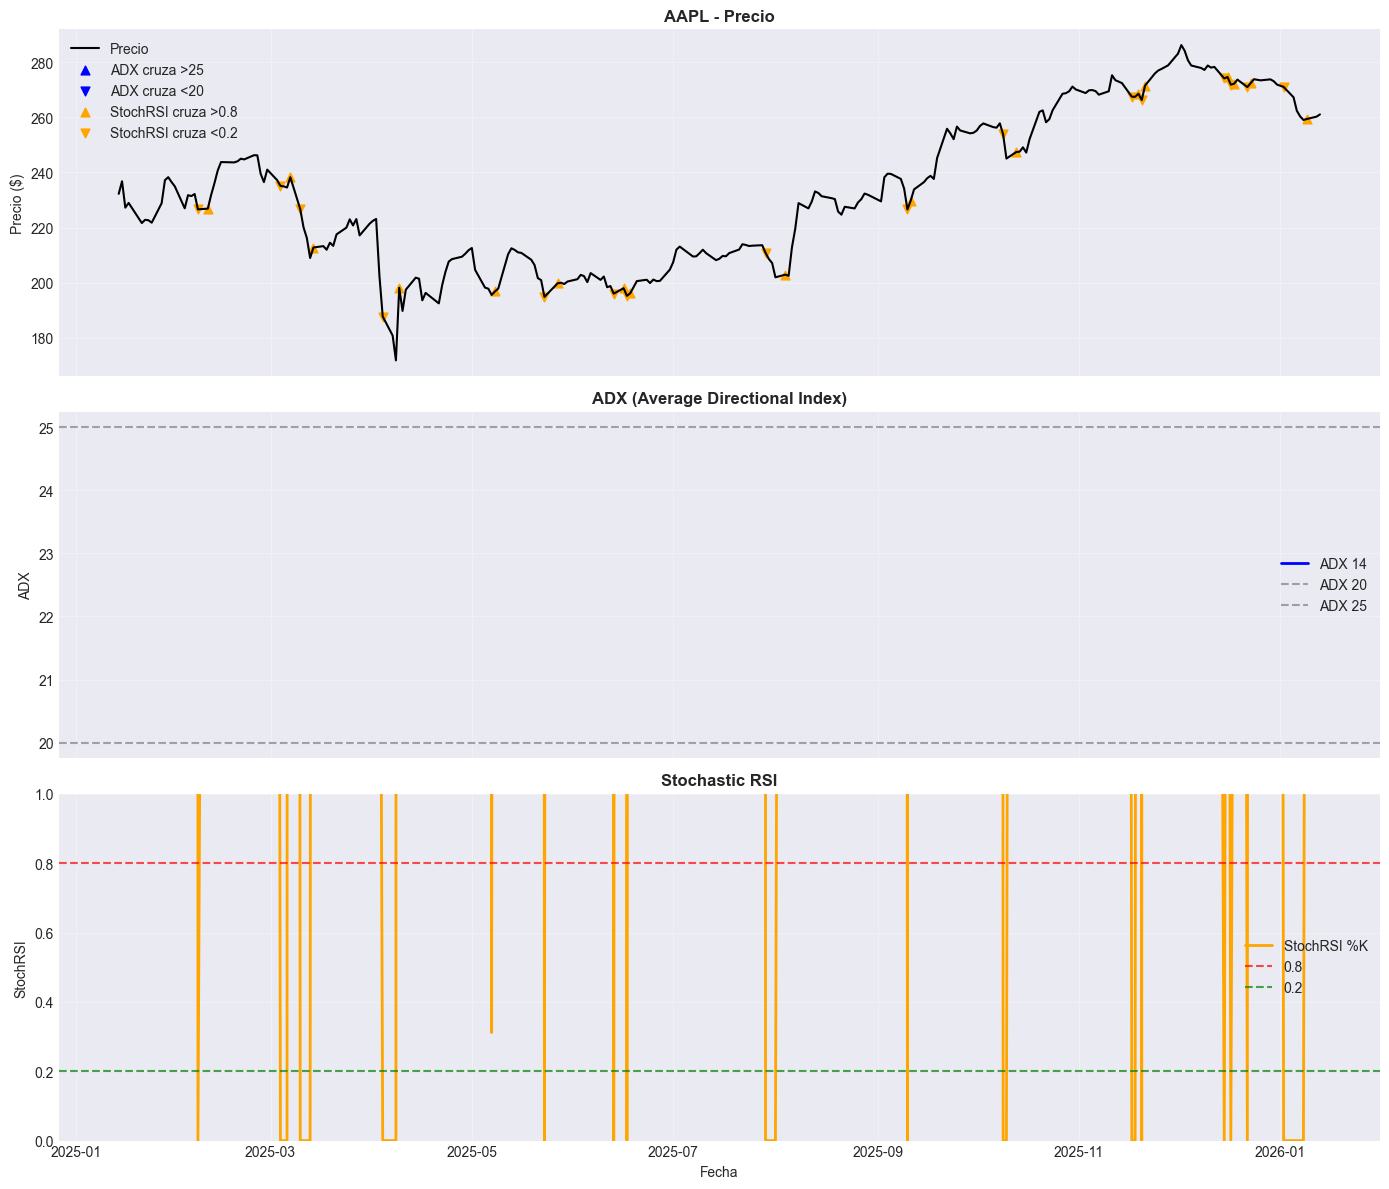

In [5]:
# Calcular ADX y Stochastic RSI

df = momentum.calculate_adx(df, period=14, output_column='ADX_14')
df = momentum.calculate_stochastic_rsi(df, rsi_period=14, stoch_period=14, output_column='StochRSI')

adx = df['ADX_14']
stoch_k = df['StochRSI_K']

adx_low = 20
adx_high = 25
stoch_low = 20
stoch_high = 80

adx_cross_up = (adx > adx_high) & (adx.shift(1) <= adx_high)
adx_cross_down = (adx < adx_low) & (adx.shift(1) >= adx_low)

stoch_cross_up = (stoch_k > stoch_high) & (stoch_k.shift(1) <= stoch_high)
stoch_cross_down = (stoch_k < stoch_low) & (stoch_k.shift(1) >= stoch_low)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
ax1.plot(df.index, df['close'], label='Precio', linewidth=1.5, color='black')
ax1.scatter(df.index[adx_cross_up], df.loc[adx_cross_up, 'close'],
            color='blue', marker='^', s=40, label='ADX cruza >25')
ax1.scatter(df.index[adx_cross_down], df.loc[adx_cross_down, 'close'],
            color='blue', marker='v', s=40, label='ADX cruza <20')
ax1.scatter(df.index[stoch_cross_up], df.loc[stoch_cross_up, 'close'],
            color='orange', marker='^', s=40, label='StochRSI cruza >80')
ax1.scatter(df.index[stoch_cross_down], df.loc[stoch_cross_down, 'close'],
            color='orange', marker='v', s=40, label='StochRSI cruza <20')
ax1.set_title(f'{symbol} - Precio', fontsize=12, fontweight='bold')
ax1.set_ylabel('Precio ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(df.index, adx, label='ADX 14', color='blue', linewidth=2)
ax2.axhline(y=adx_low, color='gray', linestyle='--', alpha=0.7, label='ADX 20')
ax2.axhline(y=adx_high, color='gray', linestyle='--', alpha=0.7, label='ADX 25')
ax2.set_title('ADX (Average Directional Index)', fontsize=12, fontweight='bold')
ax2.set_ylabel('ADX')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3.plot(df.index, stoch_k, label='StochRSI %K', color='orange', linewidth=2)
ax3.axhline(y=stoch_high, color='r', linestyle='--', alpha=0.7, label='80')
ax3.axhline(y=stoch_low, color='g', linestyle='--', alpha=0.7, label='20')
ax3.set_title('Stochastic RSI', fontsize=12, fontweight='bold')
ax3.set_xlabel('Fecha')
ax3.set_ylabel('StochRSI')
ax3.set_ylim(0, 100)
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Indicadores de Volatilidad

### Bollinger Bands

ATR actual: $nan


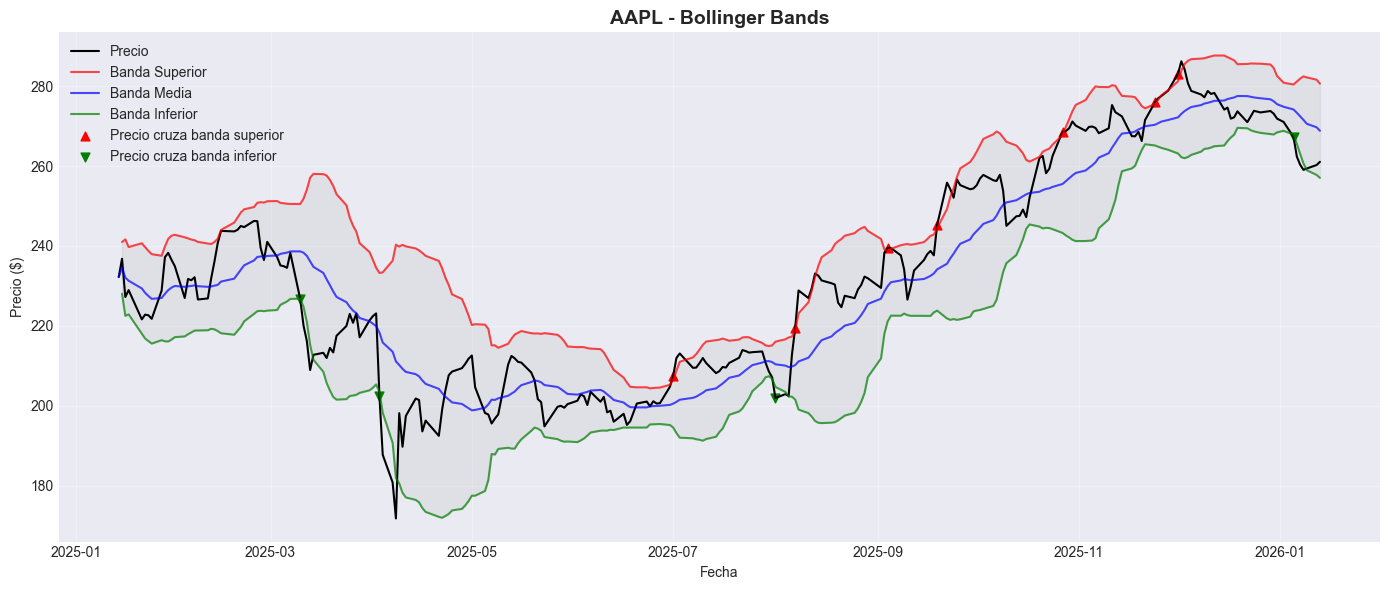

In [6]:
# Calcular Bollinger Bands y ATR
df = volatility.calculate_bollinger_bands(df, period=20, std_dev=2.0, output_prefix='BB_20')
df = volatility.calculate_atr(df, period=14, output_column='ATR_14')

atr_last = df['ATR_14'].dropna().iloc[-1]
print(f"ATR actual: ${atr_last:.2f}")

close = df['close']
upper_band = df['BB_20_Upper']
lower_band = df['BB_20_Lower']

cross_above_upper = (close > upper_band) & (close.shift(1) <= upper_band.shift(1))
cross_below_lower = (close < lower_band) & (close.shift(1) >= lower_band.shift(1))

# Visualizar Bollinger Bands y ATR
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), sharex=True, height_ratios=[2, 1])
ax1.plot(df.index, df['close'], label='Precio', linewidth=1.5, color='black')
ax1.plot(df.index, df['BB_20_Upper'], label='Banda Superior', linewidth=1.5, color='red', alpha=0.7)
ax1.plot(df.index, df['BB_20_Middle'], label='Banda Media', linewidth=1.5, color='blue', alpha=0.7)
ax1.plot(df.index, df['BB_20_Lower'], label='Banda Inferior', linewidth=1.5, color='green', alpha=0.7)
ax1.fill_between(df.index, df['BB_20_Upper'], df['BB_20_Lower'], alpha=0.1, color='gray')

ax1.scatter(df.index[cross_above_upper], close[cross_above_upper],
            color='red', marker='^', s=40, label='Precio cruza banda superior')
ax1.scatter(df.index[cross_below_lower], close[cross_below_lower],
            color='green', marker='v', s=40, label='Precio cruza banda inferior')

ax1.set_title(f'{symbol} - Bollinger Bands', fontsize=14, fontweight='bold')
ax1.set_ylabel('Precio ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(df.index, df['ATR_14'], label='ATR 14', color='purple', linewidth=1.5)
ax2.set_title('ATR (Average True Range)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('ATR')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Indicadores de Volumen

### VWAP y MFI

VWAP actual: $260.42
MFI actual: 48.69
A/D actual: 540199821.81


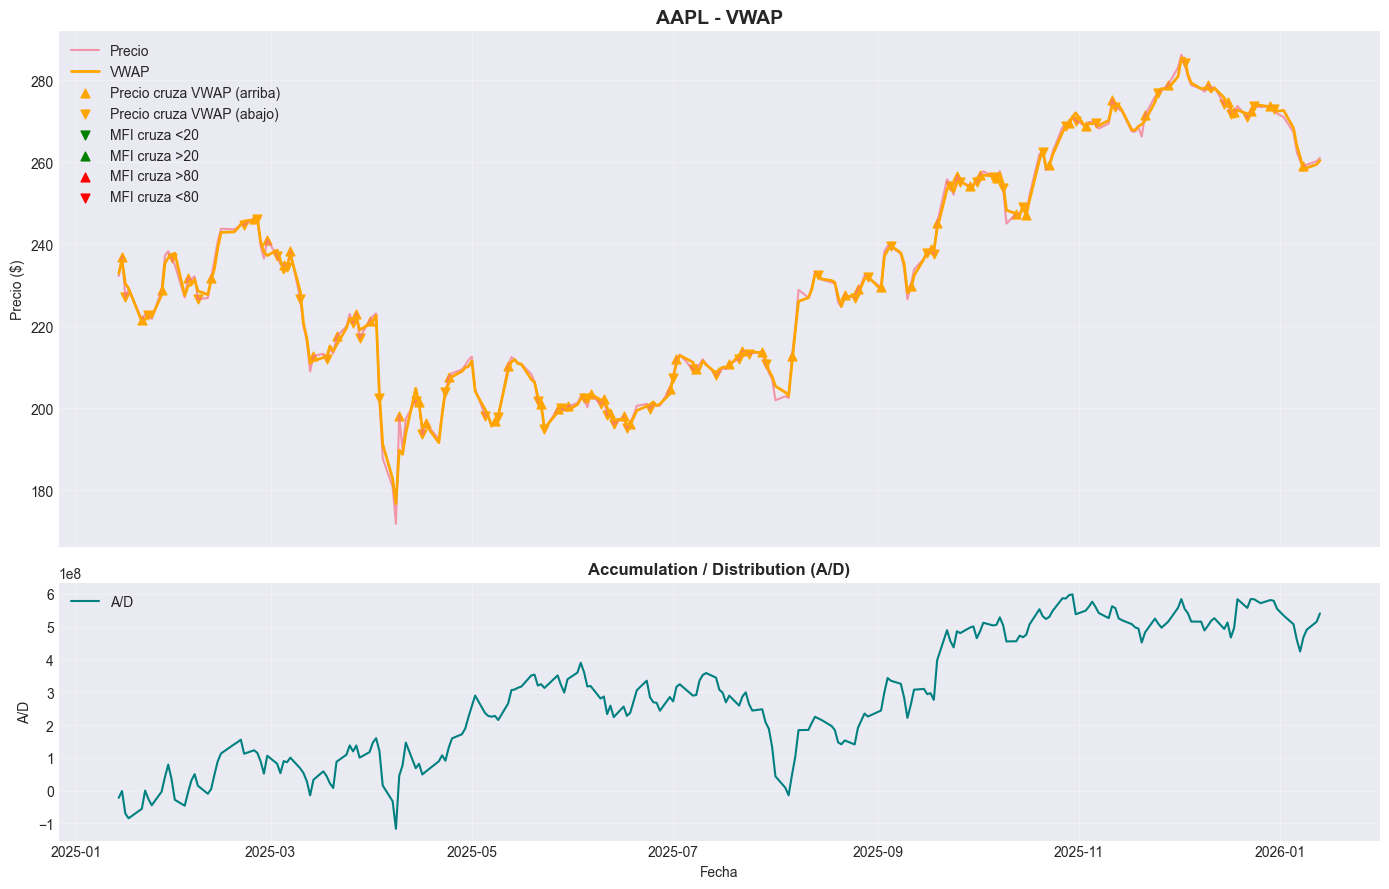

In [7]:
# Calcular VWAP, MFI y A/D

df = volume.calculate_vwap(df, output_column='VWAP')
df = volume.calculate_mfi(df, period=14, output_column='MFI_14')
df = volume.calculate_ad(df, output_column='AD')

print(f"VWAP actual: ${df['VWAP'].iloc[-1]:.2f}")
print(f"MFI actual: {df['MFI_14'].iloc[-1]:.2f}")
print(f"A/D actual: {df['AD'].iloc[-1]:.2f}")

close = df['close']
vwap = df['VWAP']
mfi = df['MFI_14']

cross_above_vwap = (close > vwap) & (close.shift(1) <= vwap.shift(1))
cross_below_vwap = (close < vwap) & (close.shift(1) >= vwap.shift(1))

lower_mfi = 20
upper_mfi = 80
cross_down_mfi = (mfi < lower_mfi) & (mfi.shift(1) >= lower_mfi)
cross_up_mfi = (mfi > lower_mfi) & (mfi.shift(1) <= lower_mfi)
cross_up_mfi_upper = (mfi > upper_mfi) & (mfi.shift(1) <= upper_mfi)
cross_down_mfi_upper = (mfi < upper_mfi) & (mfi.shift(1) >= upper_mfi)

# Visualizar VWAP y A/D
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), sharex=True, height_ratios=[2, 1])
ax1.plot(df.index, df['close'], label='Precio', linewidth=1.5, alpha=0.7)
ax1.plot(df.index, df['VWAP'], label='VWAP', linewidth=2, color='orange')

ax1.scatter(df.index[cross_above_vwap], close[cross_above_vwap],
            color='orange', marker='^', s=40, label='Precio cruza VWAP (arriba)')
ax1.scatter(df.index[cross_below_vwap], close[cross_below_vwap],
            color='orange', marker='v', s=40, label='Precio cruza VWAP (abajo)')

ax1.scatter(df.index[cross_down_mfi], close[cross_down_mfi],
            color='green', marker='v', s=40, label='MFI cruza <20')
ax1.scatter(df.index[cross_up_mfi], close[cross_up_mfi],
            color='green', marker='^', s=40, label='MFI cruza >20')
ax1.scatter(df.index[cross_up_mfi_upper], close[cross_up_mfi_upper],
            color='red', marker='^', s=40, label='MFI cruza >80')
ax1.scatter(df.index[cross_down_mfi_upper], close[cross_down_mfi_upper],
            color='red', marker='v', s=40, label='MFI cruza <80')

ax1.set_title(f'{symbol} - VWAP', fontsize=14, fontweight='bold')
ax1.set_ylabel('Precio ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(df.index, df['AD'], label='A/D', color='teal', linewidth=1.5)
ax2.set_title('Accumulation / Distribution (A/D)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('A/D')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Price Action

### Fractales, Support/Resistance y Pivot Points

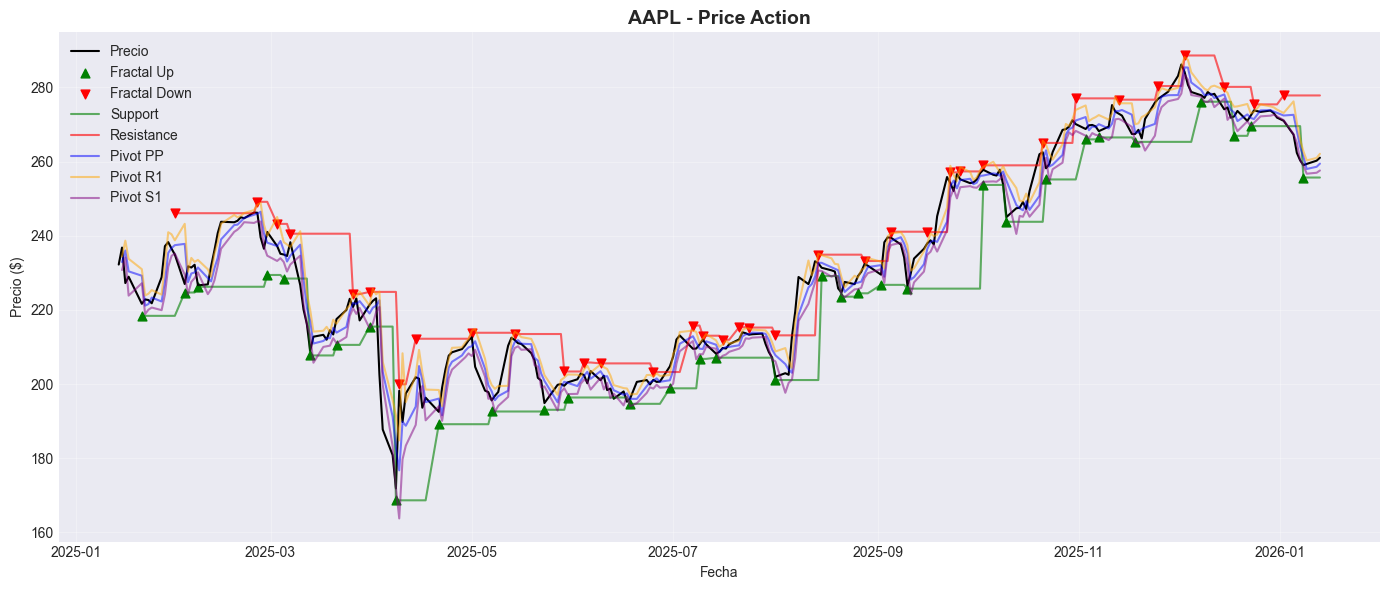

In [8]:
# Calcular fractales, soporte/resistencia y pivots
df = price_action.calculate_fractals(df, period=2, output_prefix='Fractal')
df = price_action.calculate_support_resistance(df, lookback=2, output_prefix='SR')
df = price_action.calculate_pivot_points(df, output_prefix='Pivot')

# Grafico 1: Fractales
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df.index, df['close'], label='Precio', linewidth=1.5, color='black')

fractal_up = df['Fractal_Up']
fractal_down = df['Fractal_Down']
ax.scatter(df.index[fractal_up], df.loc[fractal_up, 'low'],
           color='green', marker='^', s=40, label='Fractal Up')
ax.scatter(df.index[fractal_down], df.loc[fractal_down, 'high'],
           color='red', marker='v', s=40, label='Fractal Down')

ax.set_title(f'{symbol} - Fractales', fontsize=14, fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Grafico 2: Support/Resistance
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df.index, df['close'], label='Precio', linewidth=1.5, color='black')
ax.plot(df.index, df['SR_Support'], color='green', alpha=0.6, label='Support')
ax.plot(df.index, df['SR_Resistance'], color='red', alpha=0.6, label='Resistance')
ax.set_title(f'{symbol} - Support/Resistance', fontsize=14, fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Grafico 3: Pivot Points
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df.index, df['close'], label='Precio', linewidth=1.5, color='black')
ax.plot(df.index, df['Pivot_PP'], color='blue', alpha=0.6, label='Pivot PP')
ax.plot(df.index, df['Pivot_R1'], color='orange', alpha=0.6, label='Pivot R1')
ax.plot(df.index, df['Pivot_S1'], color='purple', alpha=0.6, label='Pivot S1')
ax.plot(df.index, df['Pivot_R2'], color='orange', alpha=0.4, label='Pivot R2')
ax.plot(df.index, df['Pivot_S2'], color='purple', alpha=0.4, label='Pivot S2')
ax.set_title(f'{symbol} - Pivot Points', fontsize=14, fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Resumen

Todos los indicadores han sido calculados y añadidos al DataFrame. Estos indicadores pueden usarse como base para análisis más avanzados y estrategias (implementadas en módulos separados).